# MACCS Keys

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette='Dark2', context='talk', font_scale=0.8)

### Load the data

In [102]:
file_ = './main_table_of_Fourches_ligs_ERK2.pkl'
with open(file_, 'rb') as f:
    df_erk2_mols = pickle.load(f)
df_erk2_mols = df_erk2_mols.set_index('Name')
# Sort the dataframe by pKi values
df_erk2_mols = df_erk2_mols.sort_values('pKi', ascending=False)

http://www.scbdd.com/pybel_desc/fps-maccs/

https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py

In [115]:
#  Let's extract the MACCS Keys as a Data frame
s = df_erk2_mols.maccs.map(lambda x: list(map(np.int, x)))
df_maccs_all = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
# We have to clarify that MACCS Keys from rdkit includes a dummy key at the begining due to the 0 indexing
# Let's drop it
df_maccs_all = df_maccs_all.drop([0], axis=1)
df_maccs_all['pKi'] = df_erk2_mols.pKi
df_maccs_all['activity'] = df_erk2_mols.activity

#### Using t-SNE to start the EDA

In [116]:
from sklearn.manifold import TSNE

In [117]:
tsne = TSNE(learning_rate=50)
X_maccs = df_maccs_all.drop(['activity', 'pKi'], axis=1)
tsne_bits = tsne.fit_transform(X_maccs)

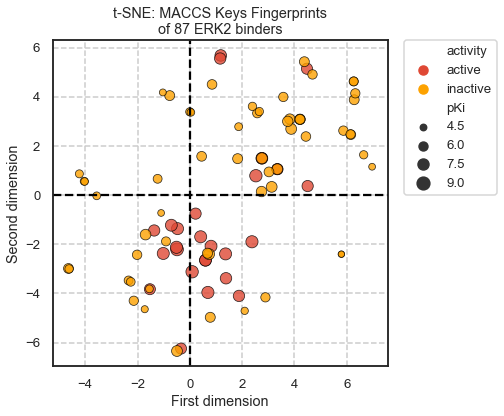

In [119]:
# Create the dataframe to plot the values
df_tsne = df_maccs_all[['pKi', 'activity']].copy()
df_tsne['activity'] = ['active' if i else 'inactive' for i in df_tsne.activity]
df_tsne['tsne_x'] = tsne_bits[:, 0]
df_tsne['tsne_y'] = tsne_bits[:, 1]

# plot the figura
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='activity', size='pKi', data=df_tsne, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.axvline(linestyle='--', color='k')
ax.axhline(linestyle='--', color='k')
ax.set(title='t-SNE: MACCS Keys Fingerprints\nof 87 ERK2 binders',
      xlabel='First dimension', ylabel='Second dimension')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

## Compute Activity Cliffs

Ash & Fourches defined an Activity Cliff between a pair of ligands (in an descriptor space) as an event in which two given molecules have an absolute difference in pKi greater than 1.5 having a Tanimoto dissimilarity of less than 0.2 (for fingerprints) or an Euclidian distance less than 6.

In [139]:
tan_mtx_dist = ssd.pdist(X_maccs, metric='jaccard')
tan_mtx_dist = ssd.squareform(tan_mtx_dist)

The two lines above give the same results as the following code using rdkit methods:
```python
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

# Get the maccs fingerprints (recomputed because we need the fps objects)
fps = [MACCSkeys.GenMACCSKeys(i) for i in df_erk2_mols.rdk_mol]

# Compute the Tanimoto similarity matrix
n_mols = len(fps)
# create an empty matrix
tan_mtx = np.zeros((n_mols, n_mols))
for i in range(1, n_mols):
    tan_coef = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
    # Add to the matrix
    tan_mtx[i,:i] = tan_coef

# Convert the lower triangle matrix to a square matrix
tan_mtx = tan_mtx + tan_mtx.T

# Fill the diagonal with ones
np.fill_diagonal(tan_mtx, 1)

# Convert to a distance matrix
tan_mtx_dist = 1 - tan_mtx 
```

#### pKi distance matrix

In [9]:
# Compute a matrix with the absolute Delta pKi values between each pair of molecules
pki_vector = df_erk2_mols.pKi.values
delta_pki_matrix = np.zeros((n_mols, n_mols))

for i in range(n_mols):
    for j in range(n_mols):
        deltas = np.abs(pki_vector[i] - pki_vector)
        # Fill the matrix
        delta_pki_matrix[i, :] = deltas

#### Tanimoto distance matrix

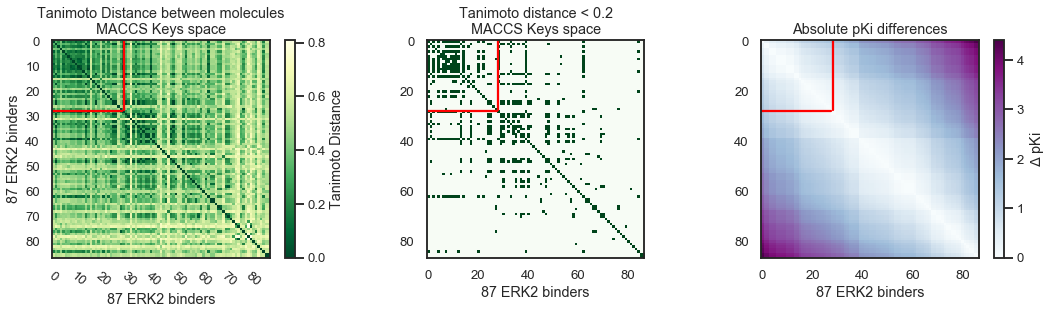

In [140]:
n_actives = df_erk2_mols.activity.sum()

fig = plt.figure(figsize=(18, 4))

# Tanimoto disimilatity matrix
plt.subplot(1,3,1)
plt.imshow(tan_mtx_dist, cmap='YlGn_r')
plt.yticks(range(0, n_mols, 10))
plt.xticks(range(0, n_mols, 10), rotation=-40)
xlabel_ = f'{n_mols} ERK2 binders'
plt.xlabel(xlabel_); plt.ylabel(xlabel_)
plt.title('Tanimoto Distance between molecules\nMACCS Keys space')

plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')

cbar1 = plt.colorbar()
cbar1.set_label('Tanimoto Distance')

# Tanimoto distance threshold
plt.subplot(1,3,2)
tan_mtx_dist_threshold = tan_mtx_dist < 0.2
# Just for visualization fill the diagonal
plt.imshow(tan_mtx_dist_threshold, cmap='Greens')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.xlabel(xlabel_)
plt.title('Tanimoto distance < 0.2\nMACCS Keys space')


# pKi deltas
plt.subplot(1,3,3)
# Just for visualization fill the diagonal
plt.imshow(delta_pki_matrix, cmap='BuPu')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.xlabel(xlabel_)
plt.title('Absolute pKi differences')

cbar2 = plt.colorbar()
cbar2.set_label('$\Delta$ pKi')

plt.show()

### Find Activity Cliffs before Feature Selection

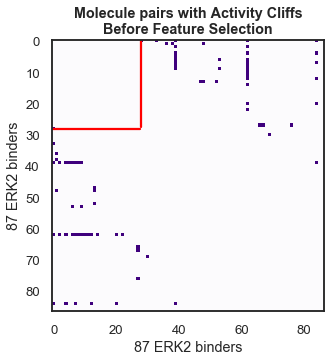

In [172]:
tan_mtx_dist_threshold = (tan_mtx_dist < 0.2) & (delta_pki_matrix > 1.5)

fig = plt.figure(figsize=(5, 5))
plt.imshow(tan_mtx_dist_threshold, cmap='Purples')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.title('Molecule pairs with Activity Cliffs\nBefore Feature Selection', fontweight='bold')
plt.xlabel(xlabel_); plt.ylabel(xlabel_)
plt.show()

## Feature Selection

**Selecting molecular descriptors following the Ash & Fourches (2017) procedure** (it is assumed that these steps were made independently for each set of descriptors):
1. **Low variance filter:** Features in the lower variance quartile were discarded.
    - This means that at least 25% of the features will be removed.
    
    
2. **Correlation filters:** For any pair of descriptors with $|r| > 0.9$ the descriptor with largest mean of $|r|$ was removed.

#### Additionally they did the following analysis (not necessarily to drop features):
1. **Pearson correlation between each descriptor and pKi values.**  
2. **Paired t-test between active and inactive ligands using each set of descriptors.**

### Variance Threshold

Ash and Fourches dropped all the features/bits inside the lower quartile of the feature variances. This meas they would remove 166/4 ~ 42 variables; however, they actually remove 45 variables (see Table 1). 

##### In our results, how many bits have only 0 or 1 values?

In [12]:
n_ones = (X_maccs.sum().values == 87).sum()
n_zeros = (X_maccs.sum().values == 0).sum()
print('Features/bits with only 1 values:', n_ones)
# How many bits have only zeros
print('Features/bits with only 0 values:', n_zeros)
# Number ofq  constant features
print('# of constant features:', n_ones + n_zeros)

Features/bits with only 1 values: 9
Features/bits with only 0 values: 37
# of constant features: 46


 We can start by droping these 42 features with only zeros, then we'll have 129 remained bits

##### Use the VarianceThreshold class from *sklearn*:

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
sel_var = VarianceThreshold(0)
df_maccs_flt1 = sel_var.fit_transform(X_maccs)
df_maccs_flt1.shape

(87, 120)

##### Boolean features (Bernoulli rvs)
Assuming each descriptor is a Bernoulli random variable with $p = n_a/N$:
> $var(x) = p(1 - p)$

In [15]:
n = 87
p = X_maccs.sum()/n
var = p*(1-p)
# As expected the result is the  same as the given by sklearn
q = np.percentile(var.values, 25)
X_maccs_flt_var = X_maccs.loc[:, var.values > q]
X_maccs_flt_var.shape

(87, 120)

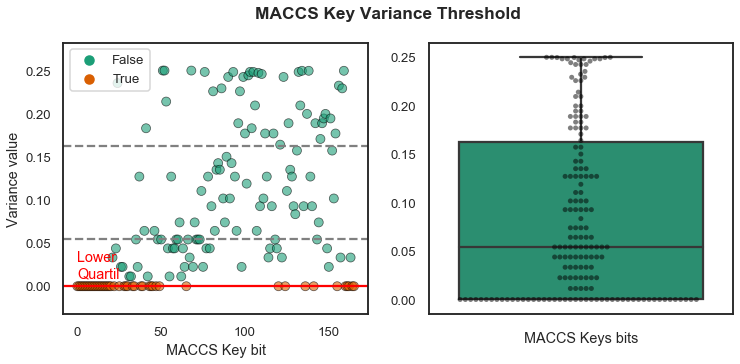

46 features were dropped.


In [173]:
# Plot variances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('MACCS Key Variance Threshold', fontweight='bold')
q1, q2, q3 = np.quantile(var.values, [0.25, 0.5, 0.75])

ax1 = sns.scatterplot(x=range(0,166), y=var, ax=ax1, hue=(var <= q1), edgecolor='k', alpha = 0.6)
ax1.set(xlabel='MACCS Key bit', ylabel='Variance value')
ax1.annotate('Lower\nQuartil', xy=(0, q1+0.01), color='red')
ax1.axhline(q1, color='red')
ax1.axhline(q2, color='grey', linestyle='--')
ax1.axhline(q3, color='grey', linestyle='--')

ax2 = sns.boxplot(y=var, ax=ax2)
ax2 = sns.swarmplot(y=var, ax=ax2, color='black', alpha=0.5)
ax2.set(xlabel='MACCS Keys bits')
plt.show()

print(sum(var <= q1), 'features were dropped.')

#### Visualizing the remained features

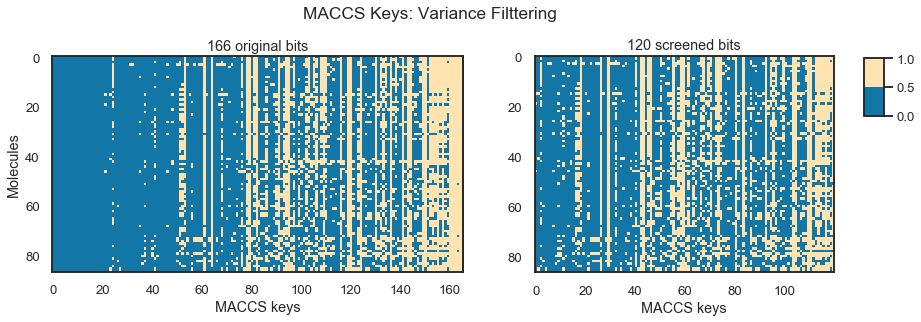

In [17]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

# colormap
cmap_heatmap = ListedColormap(['#1276a7', '#FFE4B1'])

gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[1.1, 0.8])
fig = plt.figure(figsize=(14, 4))
fig.suptitle('MACCS Keys: Variance Filttering', y = 1.05, fontweight='bold')
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xlab = 'MACCS keys'
s = ax1.imshow(X_maccs, cmap =cmap_heatmap)
ax1.set(title='166 original bits', xlabel=xlab, ylabel='Molecules')
ax2.imshow(X_maccs_flt_var, cmap=cmap_heatmap)
ax2.set(title='120 screened bits', xlabel=xlab)
fig.colorbar(s, ax=ax1, cax=fig.add_axes([0.93, 0.67, 0.02, 0.2]))
plt.show()

## Correlation Filtering 

### Python implementation
#### Matthews correlation coefficient (phi corr. coef.)

In [18]:
from sklearn.metrics import matthews_corrcoef
from correlation_filter import *

-0.1956151991089879


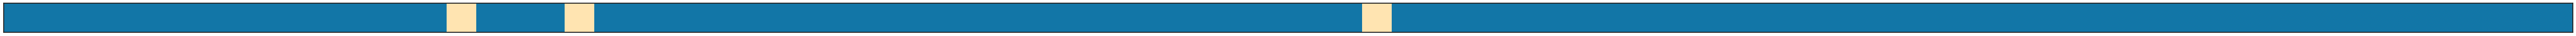

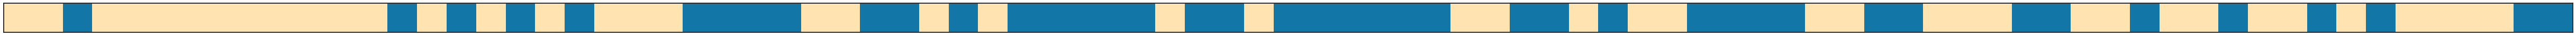

In [19]:
print(matthews_corrcoef(X_maccs_flt_var[ 22 ],
                  X_maccs_flt_var[ 160 ]))

bit_92_palette = ['#FFE4B1' if i else '#1276a7' for i in X_maccs_flt_var[22].values]
sns.palplot(sns.color_palette(bit_92_palette))

bit_110_palette = ['#FFE4B1' if i else '#1276a7' for i in X_maccs_flt_var[160].values]
sns.palplot(sns.color_palette(bit_110_palette))

Compute **phi correlation** for all the features.

In [20]:
from sklearn.metrics import matthews_corrcoef
def get_phi_correlation_matrix(df, return_df=True):
    '''Computes Matthews Correalation coefficient given a tidy DataFrame'''
    n_features = len(df.columns)
    # Create the empty matrix
    phi_corr_mtx = np.zeros((n_features, n_features))
    for idx_i, f_i in enumerate(df.columns):
        for idx_j, f_j in enumerate(df.columns):
            phi = matthews_corrcoef(df[f_i], df[f_j])
            # Add value to the matrix
            phi_corr_mtx[idx_i, idx_j] = phi
    if return_df:
        phi_corr_mtx = pd.DataFrame(phi_corr_mtx, columns=df.columns, index=df.columns)
    return phi_corr_mtx

Get the Matthews correlation coefficient:

In [21]:
df_macc_phi_corr = get_phi_correlation_matrix(X_maccs_flt_var, return_df=True)

In [22]:
#features_to_drop(df_tan, max_thr = 1, min_thr = 0.99, step =  0.01, verbose = False)
features_to_drop_mcc = features_to_drop(dataset=X_maccs_flt_var, correlated_mtx = df_macc_phi_corr, 
                         max_thr = 1, min_thr = 0.9, step =  0.01, verbose = False, absoluted=True)
len(features_to_drop_mcc)

23

In [23]:
X_maccs_flt_phi = X_maccs_flt_var.drop(features_to_drop_mcc, axis=1)
X_maccs_flt_phi.shape

(87, 97)

### R implementation

The following R code let us to achieve the same phi correlation matrix:

```python
%load_ext rpy2.ipython
```
   

```R
%%R -i X_maccs_flt_var -o phi_corr_mtx_R

df <- X_maccs_flt_var
# Compute the correlation matrix
n_cols <- ncol(X_maccs_flt_var)
# Define an emty matrix
phi_corr_mtx_R <- matrix(, nrow=n_cols, ncol=n_cols)

for(col_i in c(1:n_cols)) {
    for(col_j in c(1:n_cols)) {
        # Get the confusion matrix as required by phi
        conf_mtx <- caret::confusionMatrix(table(data=df[, col_i],
                                                 reference=df[, col_j]))$table
        phi_val <- psych::phi(conf_mtx, digits = 5)
        phi_corr_mtx_R[col_i, col_j] <- phi_val
    }
}

```

#### Drop correlated features using `caret`

In [24]:
%load_ext rpy2.ipython

In [25]:
%%R -i df_macc_phi_corr -o cols_to_drop_CARET

corr_mtx <- as.matrix(df_macc_phi_corr)
cols_to_drop_CARET <- caret::findCorrelation(corr_mtx, cutoff=0.9, exact=TRUE, names=TRUE)
cols_to_drop_CARET

 [1] "51"  "60"  "61"  "67"  "127" "55"  "88"  "83"  "59"  "94"  "69"  "133"
[13] "105" "107" "92"  "154" "117" "28"  "65"  "36"  "99"  "118" "33"  "63" 


Omitted:

In [26]:
#X_maccs_flt_phi = X_maccs_flt_var.drop(cols_to_drop_CARET.astype(int), axis=1)
#X_maccs_flt_phi.shape

### Visualization before and after correlation

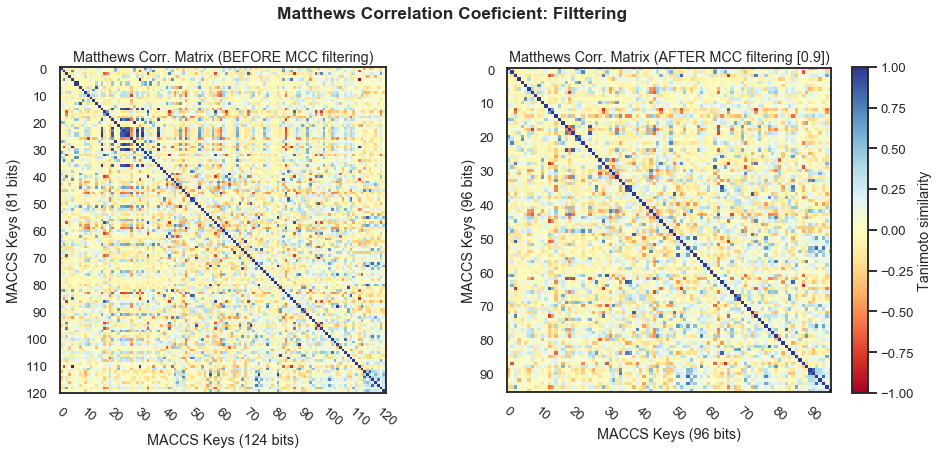

In [174]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Matthews Correlation Coeficient: Filttering', y = 1.02, fontweight='bold')

plt.subplot(1, 2, 1)
plt.imshow(df_macc_phi_corr, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, 125, 10))
plt.xticks(range(0, 125, 10), rotation=-40)
plt.xlabel('MACCS Keys (124 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Matthews Corr. Matrix (BEFORE MCC filtering)')

plt.subplot(1, 2, 2)
remainded_feat = cols_to_drop_CARET.astype(int)
df_macc_phi_corr_filtered = df_macc_phi_corr.drop(remainded_feat, axis=1).drop(remainded_feat, axis=0)
n_new_feat = len(df_macc_phi_corr_filtered)
plt.imshow(df_macc_phi_corr_filtered, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_new_feat, 10))
plt.xticks(range(0, n_new_feat, 10), rotation=-40)
plt.xlabel(f'MACCS Keys ({n_new_feat} bits)')
plt.ylabel(F'MACCS Keys ({n_new_feat} bits)')
plt.title('Matthews Corr. Matrix (AFTER MCC filtering [0.9])')

cbar = plt.colorbar()
cbar.set_label('Tanimoto similarity')
plt.show()

### Tanimoto similarity between MACCS Keys bits

In [28]:
from scipy.spatial.distance import pdist, squareform
from correlation_filter import *

In [29]:
# Better than correlation, we should use a similarity metric to compare the binary vectors
# From this perspective we're not comparing similarity between observations, but between features
# We substract the value (distance) from 1 to get similarity
cm_jaccard = pdist(X_maccs_flt_var.T, 'jaccard') 
# Convert to a matrix and plot it
mtx_tan = 1 - squareform(cm_jaccard)
# Let's force the diagonal to have values above 1 to distinguish between these values
np.fill_diagonal(mtx_tan, 1.1)
# convert to  a DataFrame
df_tan = pd.DataFrame(mtx_tan, index=X_maccs_flt_var.columns, columns=X_maccs_flt_var.columns)

As an example let's visualize features with similar behavior inside the dataset

Features 83 and 120 have a Tanimoto coef. of: 0.9759036144578314


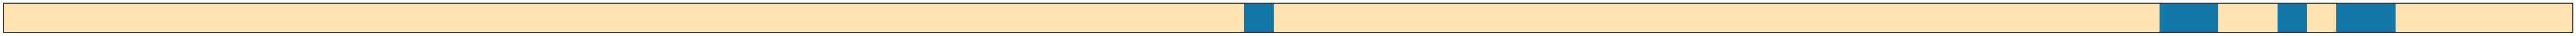

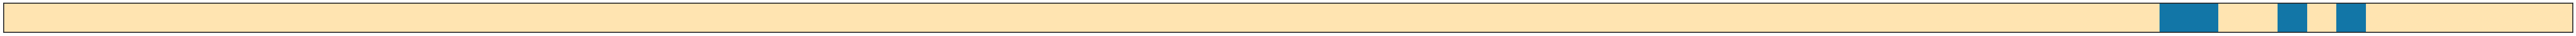

In [30]:
tan_max_idx1_ie = df_tan[df_tan < 0.98].max().idxmax()
tan_max_idx2_ie = df_tan[df_tan < 0.98].loc[: , tan_max_idx1_ie].idxmax()
tan_coef_value_example = df_tan.loc[tan_max_idx1_ie, tan_max_idx2_ie]

# Example
print('Features', tan_max_idx1_ie, 'and', tan_max_idx2_ie, 'have a Tanimoto coef. of:', tan_coef_value_example)
# Plot them
bit_92_palette = ['#FFE4B1' if i else '#1276a7' for i in X_maccs_flt_var.loc[:, tan_max_idx1_ie].values]
sns.palplot(sns.color_palette(bit_92_palette))

bit_110_palette = ['#FFE4B1' if i else '#1276a7' for i in X_maccs_flt_var.loc[:, tan_max_idx2_ie].values]
sns.palplot(sns.color_palette(bit_110_palette))

#### Dropping features (bits)
Adapting the strategy used by Fourches;
1. We're  going to sum all Tanimoto  coefficients per each feature.
2. We'll identify all feature pairs with Tanimoto coefficient higher than 0.95

#### Using jaccard through scipy

In [31]:
bits_to_drop = features_to_drop(df_tan, max_thr = 1, min_thr = 0.99, step =  0.01, verbose = False)
# Drop the features:
X_maccs_flt_tan = X_maccs_flt_var.drop(bits_to_drop, axis=1)


# Get the new tanimoto matrix just to plot and compare
_cm_jaccard = pdist(X_maccs_flt_tan.T, 'jaccard') 
_mtx_tan = 1 - squareform(_cm_jaccard)
np.fill_diagonal(_mtx_tan, 1.1)
_df_tan = pd.DataFrame(_mtx_tan, index=X_maccs_flt_tan.columns, columns=X_maccs_flt_tan.columns)

#### Visualization before and after feature selection

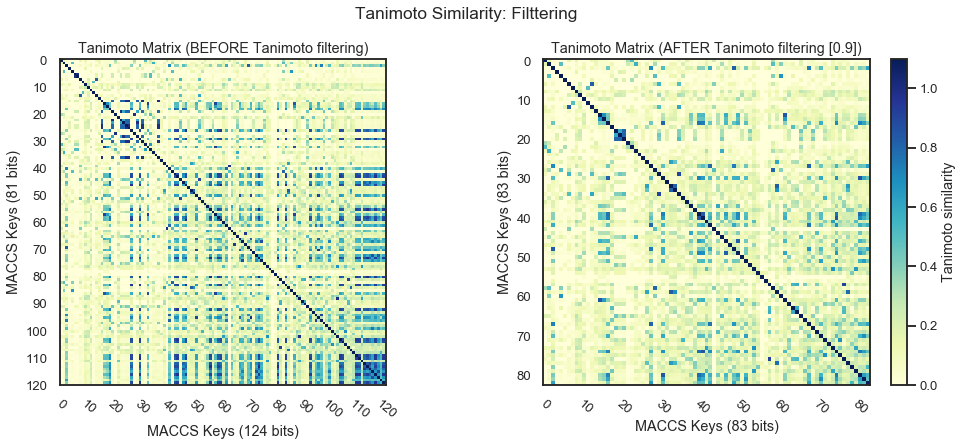

In [32]:
fig = plt.figure(figsize=(17, 6))
plt.suptitle('Tanimoto Similarity: Filttering', y=1., fontweight='bold')

plt.subplot(1, 2, 1)
plt.imshow(df_tan, cmap='YlGnBu')
plt.yticks(range(0, 125, 10))
plt.xticks(range(0, 125, 10), rotation=-40)
plt.xlabel('MACCS Keys (124 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Tanimoto Matrix (BEFORE Tanimoto filtering)')

plt.subplot(1, 2, 2)
plt.imshow(_df_tan, cmap='YlGnBu')
n_tan_feat = X_maccs_flt_tan.shape[1]
plt.yticks(range(0, n_tan_feat, 10))
plt.xticks(range(0, n_tan_feat, 10), rotation=-40)
plt.xlabel(f'MACCS Keys ({n_tan_feat} bits)'); plt.ylabel(f'MACCS Keys ({n_tan_feat} bits)')
plt.title('Tanimoto Matrix (AFTER Tanimoto filtering [0.9])')

cbar = plt.colorbar()
cbar.set_label('Tanimoto similarity')
plt.show()

Which features are the same between those filter with MCC and Tanimoto coefficients:

In [33]:
len(set(X_maccs_flt_phi.columns.tolist()) & set(X_maccs_flt_tan.columns.tolist()))

73

## Correlation of 97 bits with pKi values
To evaluate the correlation between pKi values ( a continue variable) and a bit from MACCS Keys, Ash and Fourches used the *point-biserial* correlation coefficient:

$$r_{pb} = \frac{\bar{Y_1} - \bar{Y_0}}{s_g}\sqrt{\frac{N_1 N_2}{N(N-1)}}$$

where $Y_0$ and $Y_1$ are means of the metric observations (given by the binary variable) coded 0 and 1; $N_0$ and $N_1$ are the number of observations coded as 0 and 1, respectively; $N$ is the total number of observations and $s_g$ is the standard deviation of all the metric observations.

In [34]:
from scipy.stats import pointbiserialr

### Let's see an example (bit113 or bit54?)

Ash & Fourches indicate that some MACCS Key bits have correlations with pKi values lower than 0.6. In particular, they mention <b style='color: red'>bit 113</b> which, as they report, had a correlation of 0.59 with pKi values. This descriptor is <i>'Onot%A%A'</i>. This descriptor can be found [here](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py).


> However this doesn't match our results because (as we will see later in this notebook):

<div style='background-color: #F9E5AB; padding: 1px 2px 5px 10px; font-size: 1em;'>
    <p>
     Ash & Fouches  <b style='color: red'>flipped the bit's names</b> . Which means that the bit 113 they report is actually the <b>bit 54</b> (167 - 113), that evaluates the presence/absence of the  carbonil group.
    </p>
</div>


#### Remember that molecules are arranged by pKi values

CSAR_erk2_18    9.00
CSAR_erk2_20    8.70
erk2_54         8.70
CSAR_erk2_17    8.52
erk2_53         8.52
                ... 
CSAR_erk2_38    4.89
CSAR_erk2_1     4.82
CSAR_erk2_21    4.80
erk2_02         4.64
erk2_01         4.60
Name: pKi, Length: 87, dtype: float64


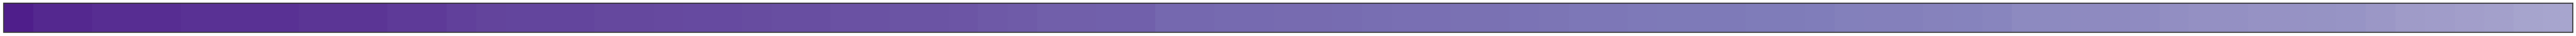

In [35]:
Purples = plt.get_cmap('Purples')
pKi_colors = Purples(df_maccs_all.pKi/10)
print(df_maccs_all.pKi)
sns.palplot(sns.color_palette(pKi_colors))

#### bit 113

PointbiserialrResult(correlation=-0.11150984541331135, pvalue=0.3038265757811512)

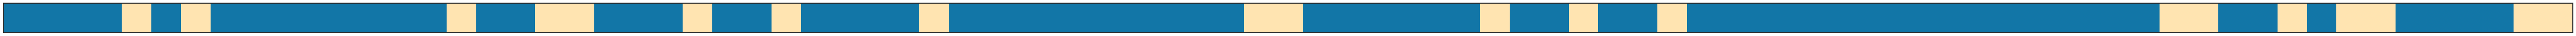

In [36]:
# Example
bit113 = X_maccs_flt_phi[113]
bit113_palette = ['#FFE4B1' if i else '#1276a7' for i in bit113]
sns.palplot(sns.color_palette(bit113_palette))

# Compute the point-biserial correaltion
pointbiserialr(bit113, df_maccs_all.pKi)

As can be seen, the point-biserial  correaltion ($r_{pb}$) between bit113 and the pKi values is 0.115, and, with a p-value of 0.3, that $r_{pb}$ is  not even significantly distinct from zero.

#### bit54

PointbiserialrResult(correlation=0.5929981381552595, pvalue=1.4325994900989657e-09)

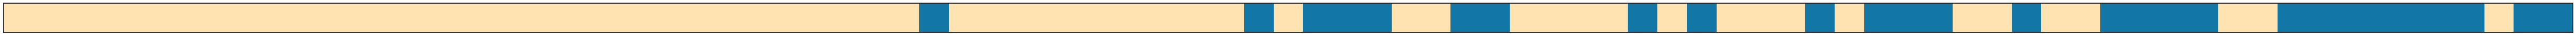

In [37]:
# Example bit54
bit54 = X_maccs_flt_phi[54]
bit54_palette = ['#FFE4B1' if i else '#1276a7' for i in bit54]
sns.palplot(sns.color_palette(bit54_palette))

# Compute the point-biserial correaltion
pointbiserialr(bit54, df_maccs_all.pKi)

This indicates that the true bit, with a $r_{pb} = 0.59$ is the bit 54, which is related to the presence/absence of the carbonil group (C=O).

#### Having this clear, let's correlate all bits with the pKi values

In [38]:
maccs_keys_corr_values_with_pki = [pointbiserialr(bit, df_maccs_all.pKi)
                                   for i, bit in X_maccs_flt_phi.iteritems()]

df_maccs_corr_pb_pki = pd.DataFrame({
          'bit': X_maccs_flt_phi.columns,
          'corr_pb': [i.correlation for i in maccs_keys_corr_values_with_pki],
          'p_value': [i.pvalue for i in maccs_keys_corr_values_with_pki],
          'significative': [i.pvalue < 0.05 for i in maccs_keys_corr_values_with_pki]
         })

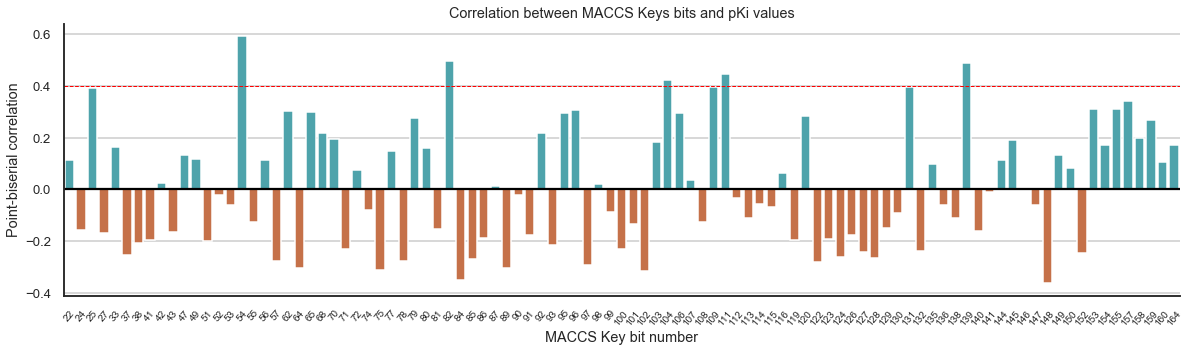

In [176]:
# plot  correlation values
color_palette = ['#3eb0ba' if i > 0 else '#da6a34' for i in df_maccs_corr_pb_pki.corr_pb]
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x='bit', y = 'corr_pb', data=df_maccs_corr_pb_pki, palette=color_palette, ax=ax)
ax.set_xticklabels(df_maccs_corr_pb_pki.bit, rotation=50, fontdict={'fontsize': 10})
ax.set(ylabel='Point-biserial correlation', xlabel='MACCS Key bit number',
       title='Correlation between MACCS Keys bits and pKi values')
plt.grid(axis='y')
plt.axhline(color='k')
plt.axhline(y=0.4, linestyle='--', linewidth=1, color='red')
sns.despine()
plt.show()

In [40]:
#ax2.annotate(tx_message, xy = (26956958,230), 
#             xytext = (26956958, 450),ha = 'right', 
#             size = 15, backgroundcolor = 'white',
#             arrowprops = {'facecolor':'black', 'width': 3})

As reported by Ash & Fourches, only 5 MACCS Keys bits have an absolute correaltion $|r_{pb}| > 0.4$ with pKi.

## Clustering: *97 bits/features remaining after MCC filtering*

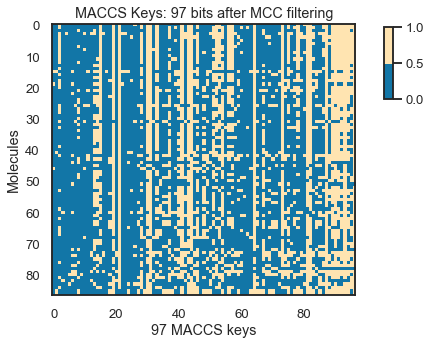

In [41]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(X_maccs_flt_phi, cmap=cmap_heatmap)
ax.set(title='MACCS Keys: 97 bits after MCC filtering', xlabel='97 MACCS keys', ylabel='Molecules')
fig.colorbar(s, ax=ax1, cax=fig.add_axes([0.93, 0.67, 0.02, 0.2]))
plt.show()

### Clustermap

In [42]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


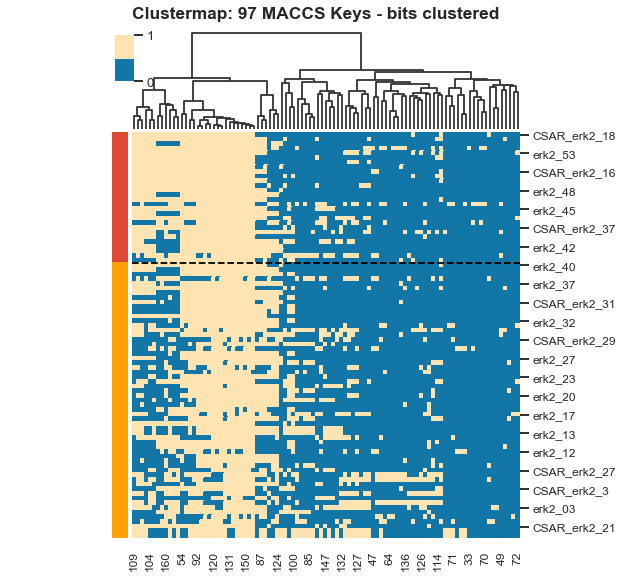

In [177]:
# Tanimoto distances (Jaccard distances) df_maccs_all
dist_tan_col = pdist(X_maccs_flt_phi.T, 'jaccard')
link_tan_col = linkage(squareform(dist_tan_col), method='average')

# Row coloring to identify Active and Inactive Molecules
colors_rows = ['#df4834' if i >= 7.5 else '#fda200' for i in df_maccs_all['pKi']]

clusmap = sns.clustermap(X_maccs_flt_phi, cmap =['#1276a7', '#FFE4B1'],
                standard_scale=1,
                row_cluster=False,
                col_linkage=link_tan_col,
                row_colors=colors_rows,
                cbar_pos=(0.19, .88, .03, .08),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 8)
              )

# Number of actives
n_actives = sum(df_maccs_all['pKi'] >= 7.5)
ax = clusmap.ax_heatmap
ax.set_xticklabels(clusmap.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
ax.hlines(y=n_actives, xmin=0, xmax=97, linewidth=1.8, linestyle='--', color = 'k')
clusmap.fig.suptitle('Clustermap: 97 MACCS Keys - bits clustered', y=1.01, fontweight='bold')
plt.show()

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


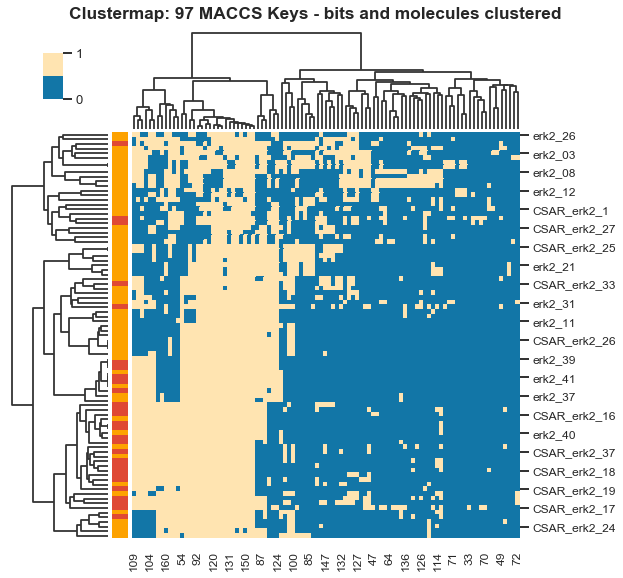

In [178]:
dist_tan_rows = pdist(X_maccs_flt_phi, 'jaccard')
link_tan_rows = linkage(squareform(dist_tan_rows), method='average', optimal_ordering=True)

clusmap = sns.clustermap(X_maccs_flt_phi, cmap =['#1276a7', '#FFE4B1'],
                standard_scale=1,
                row_linkage=link_tan_rows,
                col_linkage=link_tan_col,
                col_cluster=True,
                row_colors=colors_rows,
                cbar_pos=(0.08, .85, .03, .08),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 8)
              )

ax = clusmap.ax_heatmap
ax.set_xticklabels(clusmap.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
clusmap.fig.suptitle('Clustermap: 97 MACCS Keys - bits and molecules clustered', y=1.01, fontweight='bold')
plt.show()

### Clustermap using R
###### fastcluster and heatmap functions

In [180]:
%load_ext rpy2.ipython
# needed to run R inside the notebook

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [181]:
# Preparing the data to parse it to R
colors_rows = ['#df4834' if i >= 7.5 else '#fda200' for i in df_maccs_all['pKi']]
dist_tan_col_from_python = squareform(dist_tan_col)

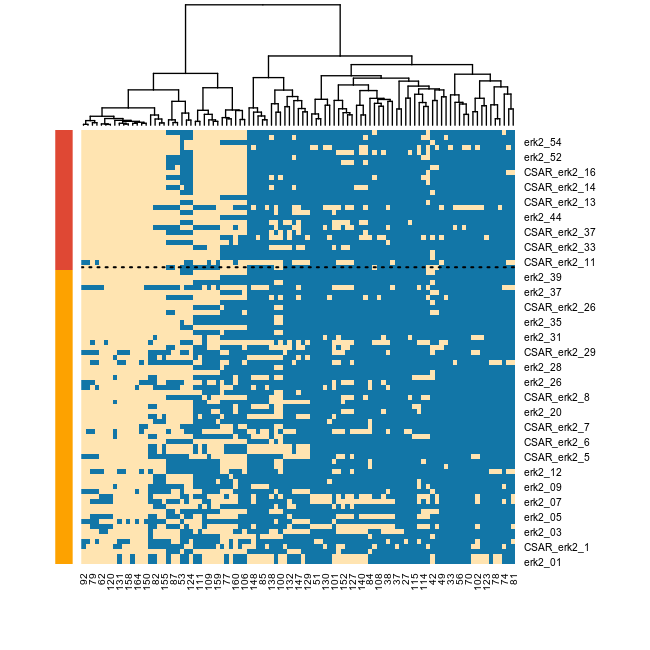

In [184]:
%%R -i X_maccs_flt_phi -i dist_tan_col_from_python -i colors_rows -w 5 -h 5 --units in -r 130

# Invert the order of rows (molecules) in the data frame and rename it
df_maccs <- X_maccs_flt_phi[rev(rownames(X_maccs_flt_phi)), ]

# Parse the distance matrix and perform the clustering using fastcluster
#dist_matx <- as.dist(dist_tan_col_from_python)
dist_matx <- vegan::vegdist(t(df_maccs), method = 'jaccard')

clust <- fastcluster::hclust(dist_matx, method='ward.D2')
# ward.D gives the most similar result (average)
dendogram <- as.dendrogram(clust)

# List of colors to identify actives/inactives
activity_colors <- rev(unlist(colors_rows))

heatmap(as.matrix(df_maccs),
        scale='row',
        Colv = dendogram,
        Rowv = NA,
        col=c('#1276a7', '#FFE4B1'),
        RowSideColors = activity_colors,
        add.expr = abline(h = c(87 - 27), lwd = 1.5, lty=3)
       )

## Logistic Regression to compare Actives against Inactives 
Ash & Fourches report that they performed **Logistic Regression** analysis to identify MACCS Keys bits that significantly show a relationship with the molecules **Activity**, i. e., bits (molecular descriptors) capable of distinguish between 'active' an 'inactive' molecules.

#### *Bits* identify by Ash and Fourches
First, let's list the 18 bits Ash & Fourches report in their supplementary material.

In [48]:
# List of 18 significative MACCS Keys reported by Fourches in Table S4
bit_number_sig_TS4 = [28, 113, 63, 41, 58, 142, 10, 85, 56, 8, 43, 36, 61, 67, 90, 88, 83, 91]
bit_number_sig_TS4.sort()
# Check if these numbers are in the
print('Bits reported by Fourches that are not presented in the set of bits filtered by us:')
[i for i in bit_number_sig_TS4 if i not in X_maccs_flt_phi.columns]

Bits reported by Fourches that are not presented in the set of bits filtered by us:


[8, 10, 28, 36, 58, 61, 63, 67, 83, 88, 142]

Interestingly, they report *bit 8* and *bit 10*, but in our analysis these bits were removed during the *variance filtering*, because these bits are constant among the whole molecules.

Bit 8


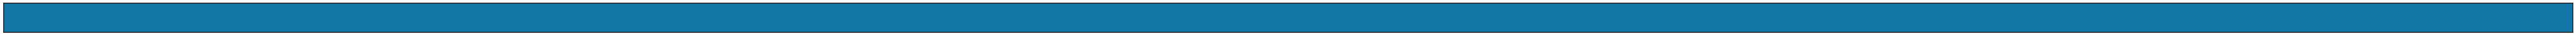

In [49]:
print('Bit 8')
bit_8_palette = ['#FFE4B1' if i else '#1276a7' for i in df_maccs_all.loc[:, 8].values]
sns.palplot(sns.color_palette(bit_8_palette))

Bit 10


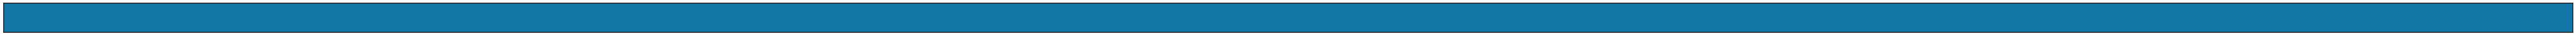

In [50]:
print('Bit 10')
bit_10_palette = ['#FFE4B1' if i else '#1276a7' for i in df_maccs_all.loc[:, 10].values]
sns.palplot(sns.color_palette(bit_10_palette))

Moreover, this behavior is the same if we consider the values computed by KNIME Node. 

In [51]:
df_macc_knime = pd.read_csv('./knime/maccs_fourches_ligs.csv', index_col=0)
print('bit 8 computed by KNIME:')
df_macc_knime['bitvector8'].values # Always 0

bit 8 computed by KNIME:


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Heatmap visualization

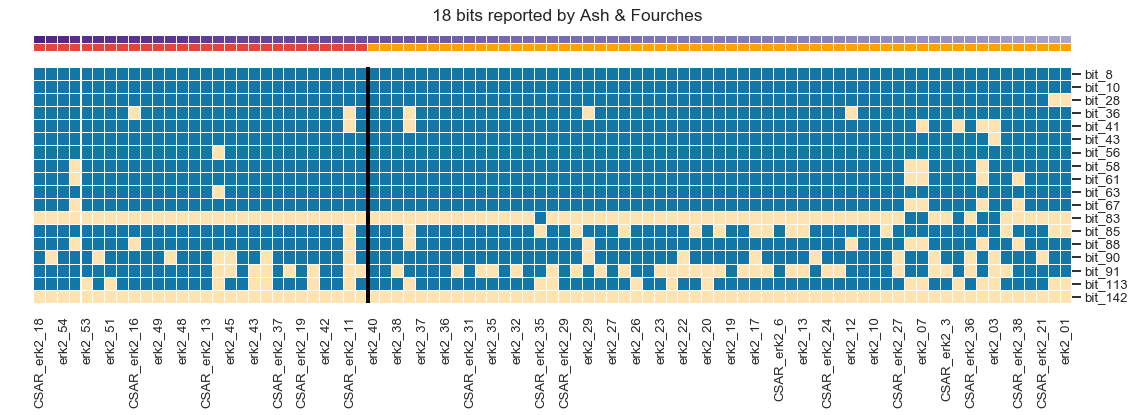

In [52]:
sig_maccs_fourches = df_maccs_all[bit_number_sig_TS4].T
sig_maccs_fourches.index = sig_maccs_fourches.index.to_series().add_prefix('bit_').index

Blues = plt.get_cmap('Purples')
pKi_colors = Blues(df_maccs_all.pKi/10)

grid = sns.clustermap(sig_maccs_fourches, cmap =['#1276a7', '#FFE4B1'],
                col_cluster=False, row_cluster=False,
                col_colors= [pKi_colors, colors_rows],
                cbar_pos=(0.15, .74, .03, .08),
                linewidths=.01,
                dendrogram_ratio = [0.01, 0.05],
                figsize=(16, 6),
              )
ax = grid.ax_heatmap
ax.vlines(x=n_actives, ymin=0, ymax=97, linewidth=4, color = 'k')
grid.cax.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
grid.fig.suptitle('18 bits reported by Ash & Fourches', y=0.96)
plt.show()

> **What happened? Why do they report these bits?**

As we mention before, Ash & Fourches flipped the MACCS Keys bits names. We'll see how these bits numbers they report are actually other bits.

### Logistic Regression (Logit function) to compare Actives between Inactives sets

In [53]:
import statsmodels.api as sm
from scipy import stats
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

#### Logit function (odds ratios)

In [54]:
X_maccs_flt_phi_to_R = X_maccs_flt_phi.copy()
X_maccs_flt_phi_to_R['activity'] = df_maccs_all.activity

In [55]:
pvalues_logit = []
coef_logit = []
bit_names = []

# Iterate over al bits and evaluate each one against activity
df_ = X_maccs_flt_phi_to_R
for bit in df_.columns:
    if (bit == 'activity') or (bit == 'pKi'):
        continue
    try:
        # Compute the logit function
        x = df_[bit]
        y = df_['activity'] # Activity values

        x2 = sm.add_constant(x) # Add constant values
        # Instantiate and fit the logit estimator
        logit_est = sm.Logit(endog=y, exog=x2).fit(disp=0)

        # Get the p-values and coeficients
        p = logit_est.pvalues[bit]
        theta = logit_est.params[bit]
    
    # If bit is a singular vector
    except np.linalg.LinAlgError:
        p = np.nan
        coef = np.nan
    # Append the values to the lists
    bit_names.append(bit)
    pvalues_logit.append(p)
    coef_logit.append(theta)

# Create the data frame
df_bits_significance = pd.DataFrame({'maccs_bit': bit_names, 'coef_theta': coef_logit, 'p_value': pvalues_logit})

#### Benjamini-Hechberg correction (FDR method)

In [56]:
from statsmodels.stats.multitest import multipletests

hb = multipletests(df_bits_significance['p_value'], alpha =0.05, is_sorted=False, method='fdr_bh')
df_bits_significance['BH_p'] = hb[1]
df_bits_significance['BH_pass'] = hb[0]

In [57]:
# Head of the final data frame
print(df_bits_significance[df_bits_significance['p_value'] <= 0.05].shape)
df_bits_significance[df_bits_significance['p_value'] <= 0.05].set_index('maccs_bit').head()

(18, 5)


,coef_theta,p_value,BH_p,BH_pass
maccs_bit,,,,
25,1.914820,0.000160,0.006495,True
77,1.337023,0.008641,0.076195,False
82,2.463167,0.001561,0.023315,True
85,-2.128232,0.045343,0.248016,False
100,-1.333185,0.011743,0.094925,False


#### How many bits significantly distinguish between actives and inactives before Benjamini-Hechberg correction?

In [155]:
df_bits_significance[df_bits_significance['p_value'] < 0.05].shape

(18, 5)

#### Extracting significative MACCS Keys bits

In [58]:
# Get the bits with a p-valuea (uncorrected) < 0.05
df_sig_BH_maccs = df_bits_significance[df_bits_significance['p_value'] <= 0.05]
sig_bits_uncorrected = df_sig_BH_maccs['maccs_bit']

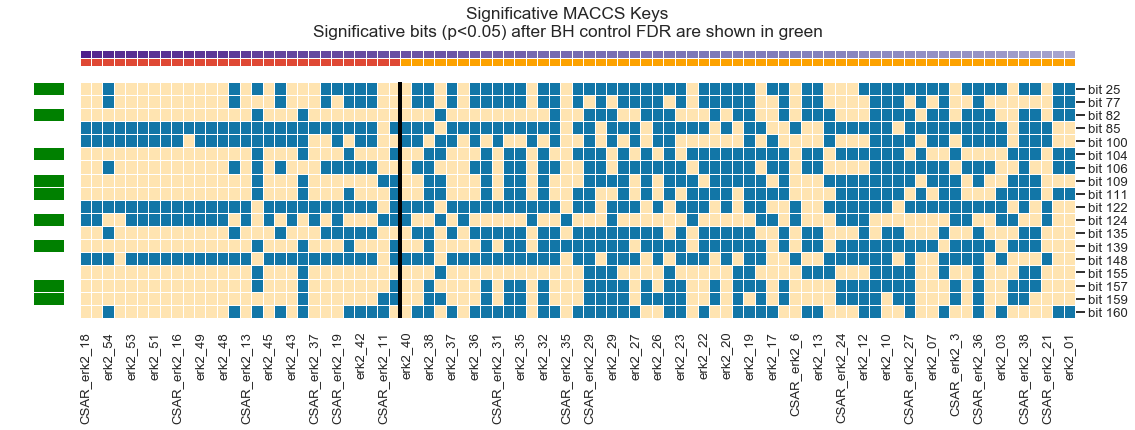

In [59]:
sig_maccs_OURS = df_maccs_all[sig_bits_uncorrected].T
sig_maccs_OURS.index = sig_maccs_OURS.index.to_series().add_prefix('bit ').index

# Column (molecular colors)
Purples = plt.get_cmap('Purples')
pKi_colors = Purples(df_maccs_all.pKi/10)
# Rows colors (bits colors by p-value)
p_valueBH_colors = ['green' if i else 'white' for i in df_sig_BH_maccs['BH_pass']]

grid = sns.clustermap(sig_maccs_OURS, cmap =['#1276a7', '#FFE4B1'],
                col_cluster=False, row_cluster=False,
                col_colors= [pKi_colors, colors_rows],
                row_colors = p_valueBH_colors,
                cbar_pos=(0.15, .74, .03, .08),
                linewidths=.01,
                dendrogram_ratio = [0.01, 0.05],
                figsize=(16, 6),
              )
ax = grid.ax_heatmap
ax.vlines(x=n_actives, ymin=0, ymax=97, linewidth=4, color = 'k')
grid.cax.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
grid.fig.suptitle('Significative MACCS Keys\nSignificative bits (p<0.05) after BH control FDR are shown in green', y=1)
plt.show()

##### Bits with p-value < 0.05 (after Benjamini-Hechberg correction)

In [156]:
signif_bits_BH = df_sig_BH_maccs[df_sig_BH_maccs['BH_pass']].set_index('maccs_bit').sort_values('BH_p')
print(signif_bits_BH.shape)
signif_bits_BH # Only 9 bits remained

(9, 4)


,coef_theta,p_value,BH_p,BH_pass
maccs_bit,,,,
139,2.614960,0.000018,0.001736,True
25,1.914820,0.000160,0.006495,True
104,2.239784,0.000201,0.006495,True
109,2.169054,0.000311,0.007553,True
111,2.099244,0.000477,0.009248,True
82,2.463167,0.001561,0.023315,True
157,2.086362,0.001683,0.023315,True
159,2.018481,0.002378,0.028831,True
124,-1.410987,0.003643,0.039261,True


#### So, what happended with the bits reported by Fourches?

In [61]:
bit_number_sig_TS4

[8, 10, 28, 36, 41, 43, 56, 58, 61, 63, 67, 83, 85, 88, 90, 91, 113, 142]

In [62]:
sorted([167 - i for i in df_bits_significance['maccs_bit'][df_bits_significance['p_value'] <= 0.05]])

[7, 8, 10, 12, 19, 28, 32, 43, 45, 56, 58, 61, 63, 67, 82, 85, 90, 142]

If we take each one of the bits we're reporting, and then we invert its name (i.e., the order) by subtracting the bit number from 167 (the total number of bits returned by KNIME or RDKit)  we'll see that the new bit names match most of those reported by Ash and Fourches. However, in their text they mention some bits (like bit91 and bit110) and their numeration match with the [MACCS Keys List available](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py), which means they started with the same bit numeration that us. Therefore, maybe they accidentally inverted the bit names (i.e. bit1 was reported as bit166, and so on).

# MACCS Keys visualization
#### Directly observe some of the significative bits

In [63]:
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
from rdkit import Chem
from matplotlib.colors import ColorConverter

In [64]:

def draw_maccs_bits(mol_list, bit_number, highlight_color='cyan', highlight_radii=0.6, **kwargs):
    # limet the number of molecules to show
    n_mols = len(mol_list)
    assert n_mols < 87, 'Number of molecules exceded!'
    maxMols = n_mols
    # get the maccs bit pattern
    maccs_pattern = Chem.MolFromSmarts(MACCSkeys.smartsPatts[bit_number][0])
    # Get the selected color
    color = ColorConverter().to_rgb( highlight_color )

    img = Draw.MolsToGridImage(mol_list, maxMols=maxMols,   
           highlightAtomLists=[ mol.GetSubstructMatch(maccs_pattern) for mol in mol_list ],
           highlightBondLists=[ mol.GetSubstructMatch(maccs_pattern) for mol in mol_list ],
           highlightAtomColors=[{atom: color for atom in mol.GetSubstructMatch(maccs_pattern)} 
                                for mol in mol_list],
                               
           highlightBondColors=[{atom: color for atom in mol.GetSubstructMatch(maccs_pattern)} 
                                for mol in mol_list],
           highlightAtomRadii=[{atom: highlight_radii for atom in mol.GetSubstructMatch(maccs_pattern)} 
                                for mol in mol_list],
           useSVG=True,
           **kwargs)
    return img

### Let's visualize bit 139 in active and inactive molecules

In [65]:
MACCSkeys.smartsPatts[139][0]

'[O;!H0]'

#### Actives

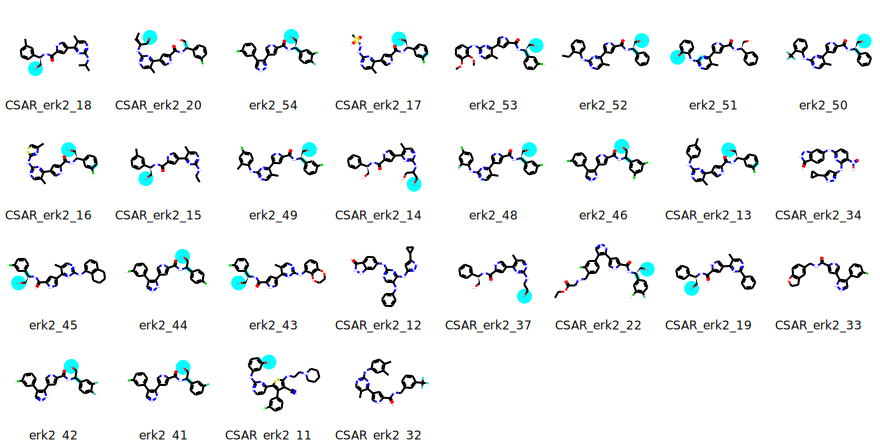

In [66]:
active_erk2_mols = df_erk2_mols.sort_values('pKi', ascending=False).loc[df_erk2_mols['activity'] == True, 'rdk_mol']

draw_maccs_bits(mol_list = active_erk2_mols, bit_number = 139,
                legends = active_erk2_mols.index.to_list(),
                highlight_radii = 1.5,
                molsPerRow=8, subImgSize=(110, 110))

#### Inactives

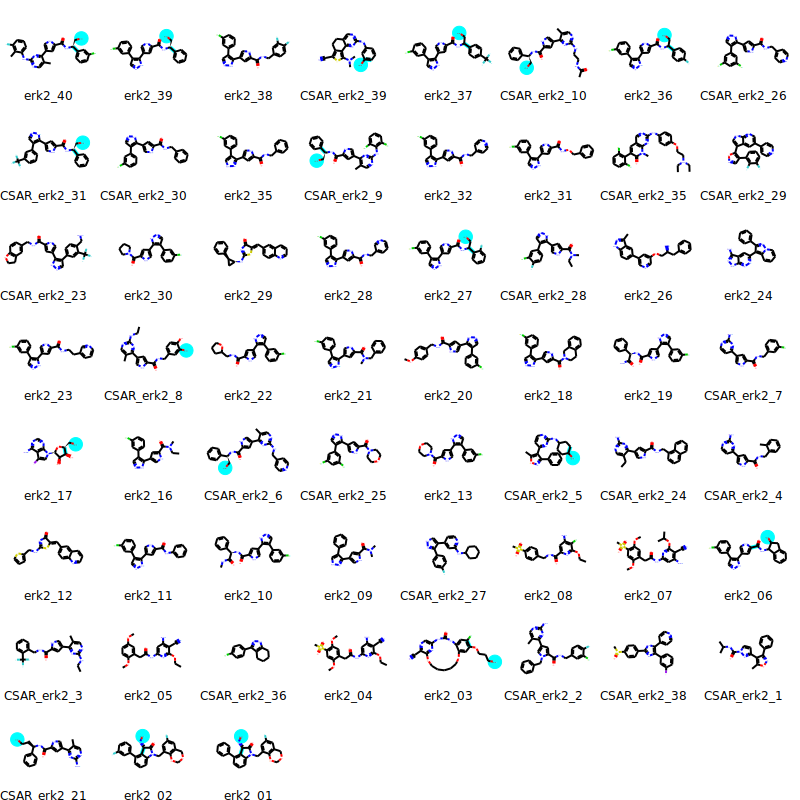

In [67]:
active_erk2_mols = df_erk2_mols.loc[df_erk2_mols['activity'] == False, 'rdk_mol']

draw_maccs_bits(mol_list = active_erk2_mols, bit_number = 139,
                legends = active_erk2_mols.index.to_list(),
                highlight_radii = 1.5,
                molsPerRow=8, subImgSize=(100, 100))

### Activity Cliffs After Feature Selection

Compute the Tanimoto distance matrix using only the 97 remained features:

In [143]:
tan_mtx_after_fs = ssd.pdist(X_maccs_flt_phi, metric='jaccard')
tan_mtx_after_fs = ssd.squareform(tan_mtx_after_fs)
tan_mtx_after_fs.shape

(87, 87)

In [166]:
signif_bits_BH_names = sorted(signif_bits_BH.index)
X_maccs_flt_sig_bits = X_maccs_flt_phi[signif_bits_BH_names]
tan_mtx_signif = ssd.pdist(X_maccs_flt_sig_bits, metric='jaccard')
tan_mtx_signif = ssd.squareform(tan_mtx_signif)
tan_mtx_signif.shape

(87, 87)

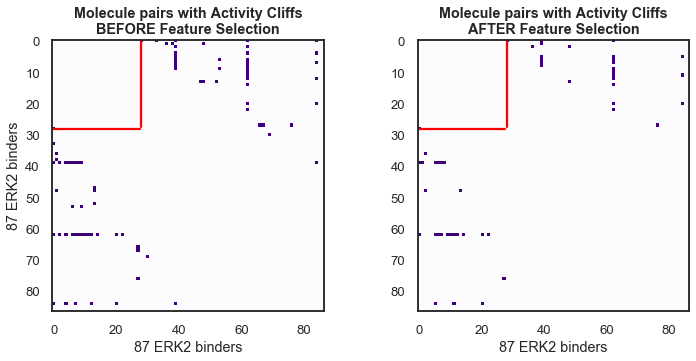

In [171]:
# Before
tan_mtx_dist_threshold_BEFORE = (tan_mtx_dist < 0.2) & (delta_pki_matrix > 1.5)

# After
tan_mtx_dist_threshold_AFTER = (tan_mtx_after_fs < 0.2) & (delta_pki_matrix > 1.5)

fig = plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(tan_mtx_dist_threshold_BEFORE, cmap='Purples')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.title('Molecule pairs with Activity Cliffs\nBEFORE Feature Selection', fontweight='bold')
plt.xlabel(xlabel_); plt.ylabel(xlabel_)

plt.subplot(1,2,2)
plt.imshow(tan_mtx_dist_threshold_AFTER, cmap='Purples')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.title('Molecule pairs with Activity Cliffs\nAFTER Feature Selection', fontweight='bold')
plt.xlabel(xlabel_)

plt.show()

In [330]:
# List of activity X_maccs_flt_phi
df_maccs_to_R = X_maccs_flt_phi.copy()
df_maccs_to_R.columns = ['bit_' + str(i) for i in df_maccs_to_R.columns]
df_maccs_to_R['activity'] = df_maccs_all.activity

In [802]:
%%R -i df_maccs_to_R

maccs_bits_names <- colnames(df_maccs_to_R[, 
                             !(names(df_maccs_to_R) 
                             %in% c('activity'))])

for(i in maccs_bits_names) {
    formula <- as.formula(paste0('activity ~ ', i))
    macss.lg <- glm(formula = formula,
                    data = df_maccs_to_R,
                    family = binomial)
    

    p_value <- coef(summary(macss.lg))[2,4]
    
    if(p_value < 0.05) {
        print(paste0(i, ': ', round(p_value, 4)))
    }
    
}

NULL


#### Recursive Feature Elimination and Logistic Regression to drop features

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [ ]:
# Define the sets
y = df_erk2_mols.activity
X = df_maccs_all

In [ ]:
# We'll use a Logistic Regression Clasifier to perform Feature Selection
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
ref_lg = RFE(estimator = lg, n_features_to_select = 97, step = 1)
ref_lg.fit(X, y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
ref_tree = RFE(estimator = tree, n_features_to_select = 97, step = 1)
ref_tree.fit(X, y)

## RDKit 2D Descriptors

In [ ]:
### KNIME

In [ ]:
rdk2d_knime = pd.read_csv('knime/2d_rdki_knime.csv')
rdk2d_knime['Filename'] = rdk2d_knime['Filename'].apply(lambda x: x.split('.')[0])
rdk2d_knime = rdk2d_knime.set_index('Filename')
rdk2d_knime = rdk2d_knime.iloc[:, 6:]

rdk2d_knime = rdk2d_knime.reindex(df_rdkit_all.index)

In [ ]:
### RDKit

In [ ]:
from rdkit.Chem import Descriptors
# MQN Descriptors go from 1 to 42
names_MQN = ['MQN' + str(i) for i in range(1, 43)]

# Final Lsit of descirptors
names_of_all_rdkit_descriptors = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
FINAL_names_of_all_rdkit_descriptors = names_of_all_rdkit_descriptors + ['CalcNumAtomStereoCenters',
                                                                        'CalcNumUnspecifiedAtomStereoCenters',
                                                                        'GetNumAtoms'] + names_MQN

In [ ]:
s = df_erk2_mols['2d_rdkit'].map(lambda x: x)
df_rdkit_all = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
df_rdkit_all.columns = FINAL_names_of_all_rdkit_descriptors
df_rdkit_all

In [ ]:
df_rdkit_all.columns

In [ ]:
rdk2d_knime.columns